<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/Data_science/playground_2023/playground_season3_ep1_skewness_handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/soumendraprasad/eda-handling-skewness-outlier-baseline 참조 스터디

### Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Library / Import Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
from lightgbm.sklearn import LGBMRegressor

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggle/playground/playground-series-s3e1/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/kaggle/playground/playground-series-s3e1/test.csv')
sub_df = pd.read_csv('/content/drive/MyDrive/kaggle/playground/playground-series-s3e1/sample_submission.csv')

## Data Shape

In [5]:
print(f'training   set shape : {train_df.shape}')
print(f'test       set shape : {test_df.shape}')
print(f'submission set shape : {sub_df.shape}')

training   set shape : (37137, 10)
test       set shape : (24759, 9)
submission set shape : (24759, 2)


In [6]:
train_df.head(3)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576


In [7]:
test_df.head(2)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29


## Data Exploration

### 결측치 확인

In [9]:
train_df.isna().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

- 결측치가 없음

### Exploring Dataset

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


In [14]:
# column 별 unique value 개수 확인
print('unique values count\n')

for i in train_df.columns:
  print("{} : {} 개".format(i, len(train_df[i].unique())))

unique values count

id : 37137 개
MedInc : 12310 개
HouseAge : 51 개
AveRooms : 22069 개
AveBedrms : 14066 개
Population : 3694 개
AveOccup : 21078 개
Latitude : 791 개
Longitude : 755 개
MedHouseVal : 3723 개


->  category형 데이터가 아닌 Numeric한 데이터임을 확인하였음

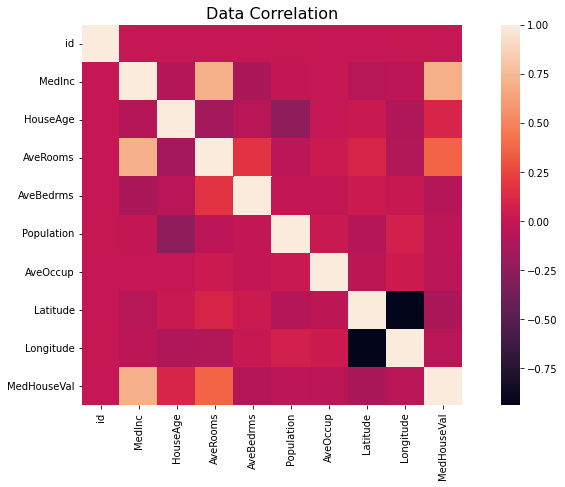

In [31]:
# Correlation 찾기

num_feat = train_df.select_dtypes(include=[np.number])  
''' select_dtypes() : type 기준 인덱싱 가능
    # include 에 넣은 값 포함
    # exclude 에 넣은 값 제외한 columns을 DataFrame 형태로 반환 
      # 숫자형(numeric : np.number | 'number')
      # 문자형(str : 'object')
      # 날짜, 시간(datetimes : np.datetime64 | 'datetime' | 'datetime64')
      #           timedeltas : np.timedelta64 | 'timedelta' | 'timedelta64'
      # categorical ('category')
'''
corr = num_feat.corr()
f, ax = plt.subplots(figsize=(14,7))
plt.title("Data Correlation", y=1, size=16)
sns.heatmap(corr, square=True, vmax=1)

- target : MedHouseVal

- target에 correlated한 col : **'Medlnc', 'HouseAge', 'AveRooms'**

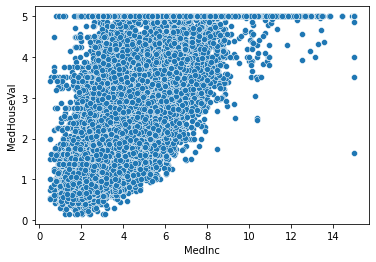

In [32]:
# looking for some relations in train dataset
sns.scatterplot(x='MedInc', y='MedHouseVal', data=train_df)

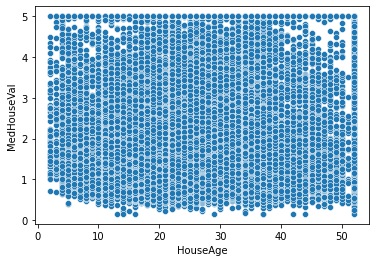

In [33]:
sns.scatterplot(x='HouseAge',y='MedHouseVal',data=train_df)

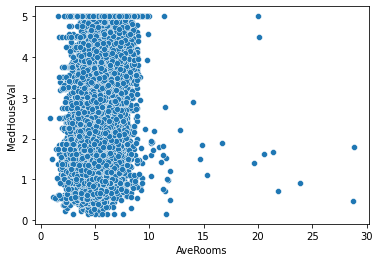

In [34]:
sns.scatterplot(x='AveRooms',y='MedHouseVal', data=train_df)

어느 정도의 결측치가 존재함을 볼 수 있음

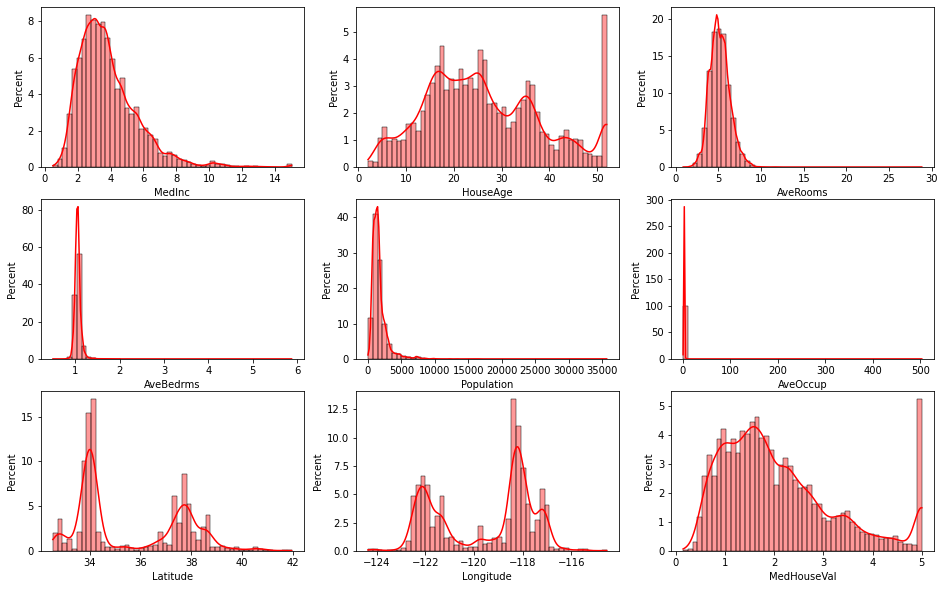

In [37]:
# Distribution of cols

n_bins= 50

histplot_hyperparams = {
    'kde': True,
    'alpha': 0.4,
    'stat' : 'percent',
    'bins': n_bins
}

# features= train_df.columns
cols = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude','MedHouseVal']

fig, ax = plt.subplots(3,3,figsize=(16,10))
ax = ax.flatten()

for i, column in enumerate(cols):
  sns.histplot(
      train_df[column], label='Train',
      ax = ax[i], color='r', **histplot_hyperparams
  )

- 완전히 정규분포를 띈 항목은 없음
- 대부분이 Right Skewed 되어 있음

## Skewdata Handling

다음과 같은 방법으로 handle 가능
- Log Transform
- Box Cox Transform
- Square Root Transform

### Log Transform

- 가장 빈번히 사용됨
- np.log()로 쉽게 사용 가능
- null이 없어야 함
- np.log(0)은 zero로 나뉘어질 수 있음

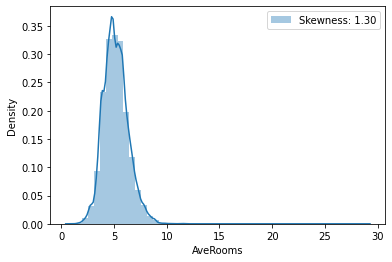

In [40]:
# 'AveRooms' col 에서의 intial skewness

t = sns.distplot(train_df['AveRooms'], label = 'Skewness: %.2f'%(train_df['AveRooms'].skew()))
t.legend()

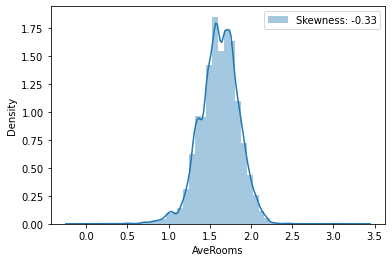

In [42]:
# Log Transform 한 후

Log_Ave = train_df['AveRooms'].map(lambda i: np.log(i) if i>0 else 0)
t = sns.distplot(Log_Ave, label="Skewness: %.2f"%(Log_Ave.skew()))
t.legend()

Skewness가 1.30 에서 -0.33으로 감소했다

### Box Cox Transform

- Data가 양수여야 한다

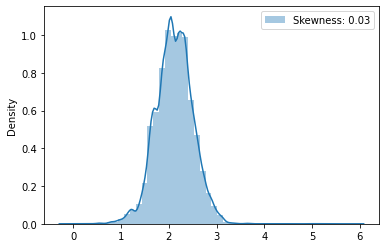

In [43]:
# from scipy import stats
Boxcox = stats.boxcox(train_df['AveRooms'])
Boxcox = pd.Series(Boxcox[0])
t = sns.distplot(Boxcox, label='Skewness: %.2f'%(Boxcox.skew()))
t.legend()

Skewness가 1.30에서 0.03으로 감소했다

### Square Root Transform

- 변수의 범위를 루트를 취함으로 줄임으로 일반적으로 사용되지 않음
- np.sqrt()를 적용시킬 수 있음

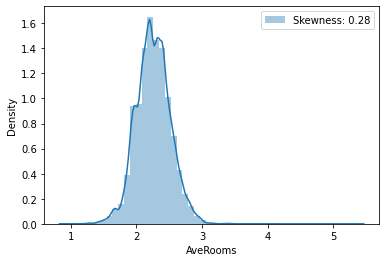

In [44]:
Sqrt_Ave = train_df['AveRooms'].map(lambda i:np.sqrt(i))
t = sns.distplot(Sqrt_Ave, label='Skewness: %.2f'%(Sqrt_Ave.skew()))
t.legend()

Skewness가 1.30에서 0.28로 줄어들었음

## Outlier 다루기

**[Outlier 원인]**
- 관측치 또는 input error
- Data corruption
- outlier observation

각 데이터에 특정되어지기 때문에, **outlier를 정의할 수 있는 정확한 방법은 없다.**

- raw 관측치에서 해석할 수 있어야 함
- outlier인지 아닌지 결정할 수 있어야 함

**[Statistical Method]**
- statistical(통계적인) 방법을 사용할 수 있음
- 이것이 outlier로 특정지을 수 있다는 것이 아니며, 또 무조건적으로 제거되어야 할 대상임을 의미하지 않는다.
- non-outlier 값들을 기반으로 문맥을 확인하여 outlier를 판별할 수 있는 systematic relationship이 있는지, 패턴이 있는지 확인할 수 있다
- outlier, non-outlier가 설명이 가능하면 systematic하게 outlier라 규정될 수 있다